### Assignment 2: telco churn prediction

submitted by: Kyal Sin Lin Lett
student id: 126112

i attest that the work done here is not plagiarized or copied entirely from others or generative ai.
the assignment is completed based on my own understanding, references to online documentations and guides
on how a similar process is implemented. the reference will be linked and referred at relevant points
in the code using comments.

In [1]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# set style for plots
# reference: https://seaborn.pydata.org/tutorial/color_palettes.html
# this is optional - purely just for aesthetics
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## loading dataset

#### how it was downloaded
downloading the dataset using `curl`

source: https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv

reference: ibm sample datasets for telco customer churn prediction.

<img src="./curl_to_download_dataset.png" width=500>

In [2]:
df = pd.read_csv("dataset/Telco-Customer-Churn.csv")

## data preprocessing

In [3]:
# convert totalcharges to numeric, coerce errors to nan
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# fill nan with median - a robust measure of central tendency
# reference: https://scikit-learn.org/stable/modules/impute.html
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# binary encoding for target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                       'PhoneService', 'MultipleLines', 'InternetService',
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies',
                       'Contract', 'PaperlessBilling', 'PaymentMethod']

# one-hot encoding for categorical variables using drop_first to avoid
# the dummy variable trap (multicollinearity among dummy columns)
# reference: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
df_encoded = pd.get_dummies(df[categorical_features], drop_first=True)

# combine numeric and encoded categorical features
X = pd.concat([df[numeric_features], df_encoded], axis=1)
y = df['Churn']

print("feature set shape:", X.shape)
print("target variable shape:", y.shape)

feature set shape: (7043, 30)
target variable shape: (7043,)


In [4]:
# splitting the dataset into training and testing sets (80/20 split)
# standardscaler is applied to normalize features to zero mean and unit variance,
# which is important for regularized models since coefficient penalties are
# scale-dependent.
# reference: https://scikit-learn.org/stable/modules/preprocessing.html#standardization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## setting alpha values

In [5]:
# using alpha=0.1 for lasso and alpha=0.1 for ridge.
# lasso's alpha controls the strength of the l1 penalty -- higher alpha
# means more aggressive feature elimination.
# reference: scikit-learn lasso documentation:
#   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
alpha_lasso = 0.1
alpha_ridge = 0.1

print(f"lasso alpha: {alpha_lasso}")
print(f"ridge alpha: {alpha_ridge}")

lasso alpha: 0.1
ridge alpha: 0.1


## training lasso and ridge models

In [6]:
# train lasso (l1 regularization) with alpha=0.1.
# lasso minimizes: (1/2n) * ||y - Xw||^2 + alpha * ||w||_1
# reference: tibshirani, r. (1996). regression shrinkage and selection via the lasso.
#   journal of the royal statistical society: series b, 58(1), 267-288.
lasso = Lasso(alpha=alpha_lasso, max_iter=10000, random_state=42)
lasso.fit(X_train_scaled, y_train)
print(f"lasso model trained (alpha={alpha_lasso})")

lasso model trained (alpha=0.1)


In [7]:
# train ridge (l2 regularization) with alpha=0.1.
# ridge minimizes: (1/2n) * ||y - Xw||^2 + alpha * ||w||_2^2
# reference: hoerl, a.e. & kennard, r.w. (1970). ridge regression: biased estimation
#   for nonorthogonal problems. technometrics, 12(1), 55-67.
ridge = Ridge(alpha=alpha_ridge, random_state=42)
ridge.fit(X_train_scaled, y_train)
print(f"ridge model trained (alpha={alpha_ridge})")

ridge model trained (alpha=0.1)


## coefficient analysis

In [8]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Lasso_Coef': lasso.coef_,
    'Ridge_Coef': ridge.coef_
})

lasso_zeros = coef_df[coef_df['Lasso_Coef'] == 0]
lasso_nonzeros = coef_df[coef_df['Lasso_Coef'] != 0]

print(f"\nLASSO RESULTS:")
print(f"   - Features kept: {len(lasso_nonzeros)}")
print(f"   - Features eliminated (set to zero): {len(lasso_zeros)}")

print("\n  Features ELIMINATED by Lasso:")
print("-" * 80)
for idx, row in lasso_zeros.head(15).iterrows():
    print(f"   • {row['Feature']:<40} (Ridge coef: {row['Ridge_Coef']:>8.4f})")
if len(lasso_zeros) > 15:
    print(f"   ... and {len(lasso_zeros) - 15} more features")

print("\n  Features KEPT by Lasso:")
print("-" * 80)
lasso_kept = lasso_nonzeros.copy()
lasso_kept['Abs_Coef'] = abs(lasso_kept['Lasso_Coef'])
lasso_kept = lasso_kept.sort_values('Abs_Coef', ascending=False)
for idx, row in lasso_kept.iterrows():
    print(f"   • {row['Feature']:<40} Lasso: {row['Lasso_Coef']:>8.4f}  Ridge: {row['Ridge_Coef']:>8.4f}")



LASSO RESULTS:
   - Features kept: 3
   - Features eliminated (set to zero): 27

  Features ELIMINATED by Lasso:
--------------------------------------------------------------------------------
   • MonthlyCharges                           (Ridge coef:  -0.1304)
   • TotalCharges                             (Ridge coef:  -0.0952)
   • SeniorCitizen                            (Ridge coef:   0.0139)
   • gender_Male                              (Ridge coef:  -0.0043)
   • Partner_Yes                              (Ridge coef:   0.0036)
   • Dependents_Yes                           (Ridge coef:  -0.0106)
   • PhoneService_Yes                         (Ridge coef:   0.0076)
   • MultipleLines_No phone service           (Ridge coef:  -0.0076)
   • MultipleLines_Yes                        (Ridge coef:   0.0350)
   • InternetService_No                       (Ridge coef:  -0.0148)
   • OnlineSecurity_No internet service       (Ridge coef:  -0.0148)
   • OnlineSecurity_Yes                       

## comparison of monthlycharges vs. totalcharges

In [9]:
# compare how lasso and ridge treat the correlated charge features
charges_comparison = coef_df[coef_df['Feature'].isin(['MonthlyCharges', 'TotalCharges'])]
print(charges_comparison.to_string(index=False))

monthly_lasso = charges_comparison[charges_comparison['Feature'] == 'MonthlyCharges']['Lasso_Coef'].values[0]
total_lasso = charges_comparison[charges_comparison['Feature'] == 'TotalCharges']['Lasso_Coef'].values[0]
monthly_ridge = charges_comparison[charges_comparison['Feature'] == 'MonthlyCharges']['Ridge_Coef'].values[0]
total_ridge = charges_comparison[charges_comparison['Feature'] == 'TotalCharges']['Ridge_Coef'].values[0]

print("\ninterpretation:")
if abs(monthly_lasso) == 0 and abs(total_lasso) == 0:
    print("   - lasso eliminated both monthlycharges and totalcharges")
    print("     (both are redundant given other features in the model)")
elif abs(monthly_lasso) > 0 and abs(total_lasso) == 0:
    print("   - lasso eliminated totalcharges (redundant with monthlycharges)")
elif abs(total_lasso) > 0 and abs(monthly_lasso) == 0:
    print("   - lasso eliminated monthlycharges (redundant with totalcharges)")
elif abs(monthly_lasso) > 0 and abs(total_lasso) > 0:
    print("   - lasso kept both (both contribute unique information)")

print(f"   - ridge kept both with coefficients: monthly={monthly_ridge:.4f}, total={total_ridge:.4f}")
print("   - ridge shrinks both but doesn't eliminate either!")

# calculate correlation between the two charge features
corr = df[['MonthlyCharges', 'TotalCharges']].corr().iloc[0, 1]
print(f"\ncorrelation between monthlycharges and totalcharges: {corr:.3f}")

       Feature  Lasso_Coef  Ridge_Coef
MonthlyCharges         0.0   -0.130352
  TotalCharges        -0.0   -0.095168

interpretation:
   - lasso eliminated both monthlycharges and totalcharges
     (both are redundant given other features in the model)
   - ridge kept both with coefficients: monthly=-0.1304, total=-0.0952
   - ridge shrinks both but doesn't eliminate either!

correlation between monthlycharges and totalcharges: 0.651


## most important features

In [10]:
coef_df['Lasso_Abs'] = abs(coef_df['Lasso_Coef'])
coef_df['Ridge_Abs'] = abs(coef_df['Ridge_Coef'])

lasso_top = coef_df.nlargest(10, 'Lasso_Abs')[['Feature', 'Lasso_Coef']]
print(lasso_top.to_string(index=False))

print("\nRidge Top 10:")
print("-" * 80)
ridge_top = coef_df.nlargest(10, 'Ridge_Abs')[['Feature', 'Ridge_Coef']]
print(ridge_top.to_string(index=False))

                       Feature  Lasso_Coef
                        tenure   -0.051036
   InternetService_Fiber optic    0.030955
PaymentMethod_Electronic check    0.010369
                MonthlyCharges    0.000000
                  TotalCharges   -0.000000
                 SeniorCitizen    0.000000
                   gender_Male   -0.000000
                   Partner_Yes   -0.000000
                Dependents_Yes   -0.000000
              PhoneService_Yes   -0.000000

Ridge Top 10:
--------------------------------------------------------------------------------
                       Feature  Ridge_Coef
   InternetService_Fiber optic    0.138246
                MonthlyCharges   -0.130352
                  TotalCharges   -0.095168
           StreamingMovies_Yes    0.051679
                        tenure   -0.046980
             Contract_One year   -0.044077
               StreamingTV_Yes    0.042426
             MultipleLines_Yes    0.035041
             Contract_Two year   -0.034411
P

## visualization

### coefficient comparison

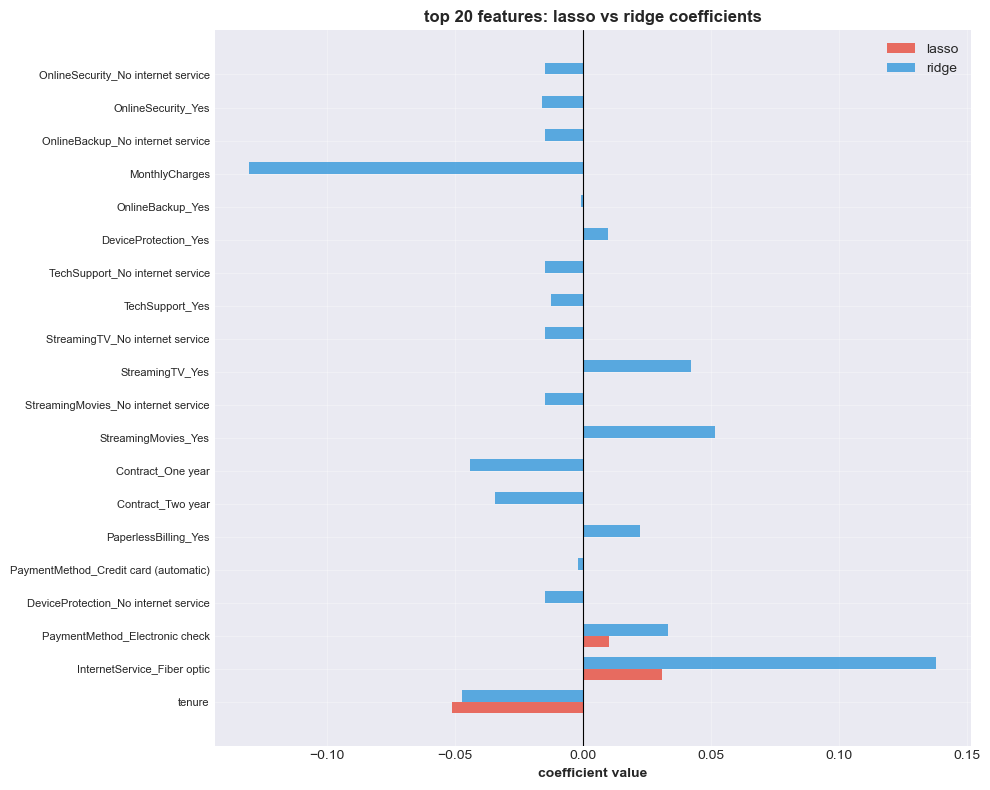

In [11]:
# comparing lasso (l1) and ridge (l2) coefficient magnitudes for top features.
# lasso performs feature selection by driving coefficients to exactly zero,
# while ridge shrinks all coefficients but retains them.
# reference: tibshirani, r. (1996). regression shrinkage and selection via the lasso.
#   journal of the royal statistical society: series b, 58(1), 267-288.
# reference: hoerl, a.e. & kennard, r.w. (1970). ridge regression: biased estimation
#   for nonorthogonal problems. technometrics, 12(1), 55-67.

fig, ax = plt.subplots(figsize=(10, 8))

coef_df_sorted = coef_df.sort_values('Lasso_Abs', ascending=False).head(20)
x_pos = np.arange(len(coef_df_sorted))
width = 0.35

bars1 = ax.barh(x_pos - width/2, coef_df_sorted['Lasso_Coef'], width, 
                 label='lasso', alpha=0.8, color='#e74c3c')
bars2 = ax.barh(x_pos + width/2, coef_df_sorted['Ridge_Coef'], width,
                 label='ridge', alpha=0.8, color='#3498db')

ax.set_yticks(x_pos)
ax.set_yticklabels(coef_df_sorted['Feature'], fontsize=8)
ax.set_xlabel('coefficient value', fontsize=10, fontweight='bold')
ax.set_title('top 20 features: lasso vs ridge coefficients', fontsize=12, fontweight='bold')
ax.legend()
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

the horizontal bar chart above compares the coefficient values assigned by lasso (red) and ridge (blue) for the top 20 features ranked by lasso's absolute coefficient magnitude. the key observation is that many features show a ridge bar but no lasso bar, this means lasso set those coefficients to exactly zero, effectively removing them from the model. for example, monthlycharges and totalcharges both have sizable ridge coefficients but are completely zeroed out by lasso. in contrast, features like tenure, internetservice_fiber optic, and paymentmethod_electronic check receive non-zero coefficients from both models, indicating they are strongly predictive of churn regardless of the regularization method used.

### feature selection pie chart

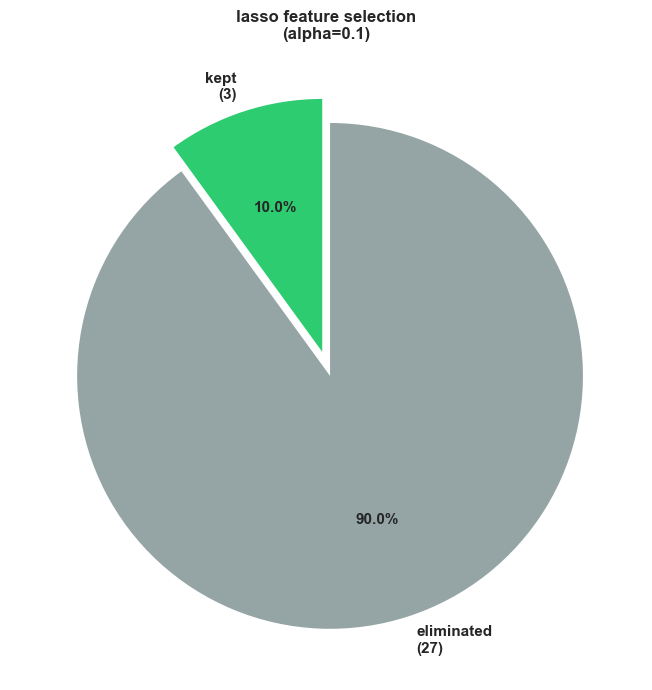

In [12]:
# pie chart showing the proportion of features kept vs eliminated by lasso.
# lasso's l1 penalty produces sparse models, which is useful for interpretability.
# reference: hastie, t., tibshirani, r., & friedman, j. (2009). the elements of
#   statistical learning (2nd ed.). springer. chapter 3.4.

fig, ax = plt.subplots(figsize=(7, 7))

elimination_data = [len(lasso_nonzeros), len(lasso_zeros)]
colors_pie = ['#2ecc71', '#95a5a6']
explode = (0.05, 0.05)

wedges, texts, autotexts = ax.pie(elimination_data, 
                                   labels=[f'kept\n({len(lasso_nonzeros)})', 
                                          f'eliminated\n({len(lasso_zeros)})'],
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   colors=colors_pie,
                                   explode=explode,
                                   textprops={'fontsize': 11, 'fontweight': 'bold'})
ax.set_title(f'lasso feature selection\n(alpha={alpha_lasso})', 
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

the pie chart shows the result of lasso's built-in feature selection at alpha=0.1. out of the original 30 features, lasso kept only 3 (10%) and eliminated 27 (90%) by setting their coefficients to zero. this aggressive elimination is a direct consequence of the relatively strong l1 penalty. the only features that survived are tenure, internetservice_fiber optic, and paymentmethod_electronic check -- the three strongest individual predictors of churn. everything else, including demographics, phone services, streaming services, and both charge features, was deemed redundant or too weakly predictive to justify its inclusion.

### monthly charges vs total charges

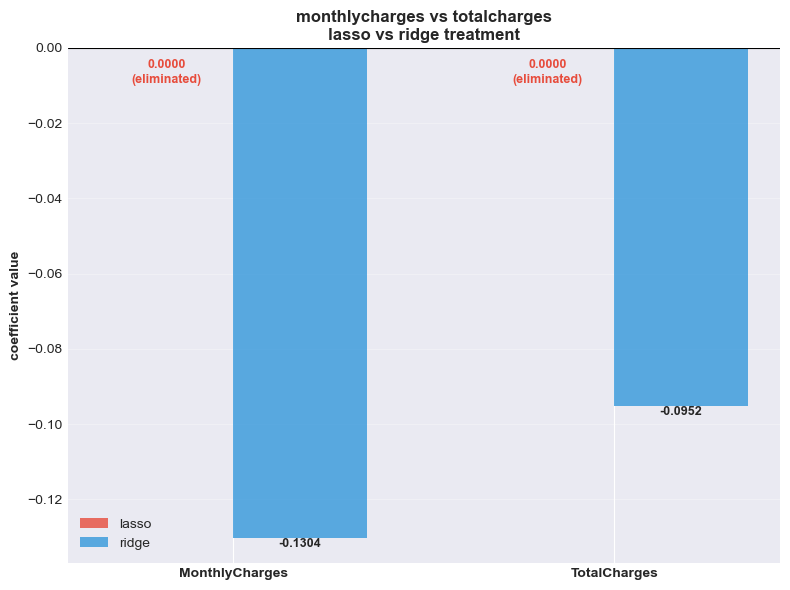

In [13]:
# bar chart comparing how lasso and ridge treat correlated features.
# monthlycharges and totalcharges are correlated (r=0.651), so lasso
# may eliminate one or both to reduce redundancy, while ridge keeps both
# with shrunken coefficients.
# reference: zou, h. & hastie, t. (2005). regularization and variable selection
#   via the elastic net. journal of the royal statistical society: series b, 67(2), 301-320.

fig, ax = plt.subplots(figsize=(8, 6))

charges_features = ['MonthlyCharges', 'TotalCharges']
lasso_charges = charges_comparison['Lasso_Coef'].values
ridge_charges = charges_comparison['Ridge_Coef'].values

x_pos = np.arange(len(charges_features))
width = 0.35

bars1 = ax.bar(x_pos - width/2, lasso_charges, width, label='lasso', 
               alpha=0.8, color='#e74c3c')
bars2 = ax.bar(x_pos + width/2, ridge_charges, width, label='ridge',
               alpha=0.8, color='#3498db')

ax.set_ylabel('coefficient value', fontweight='bold')
ax.set_title('monthlycharges vs totalcharges\nlasso vs ridge treatment', 
             fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(charges_features, fontweight='bold')
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='y')

# annotate bars with their coefficient values, including zeros for lasso
for bar in bars1:
    height = bar.get_height()
    if abs(height) <= 0.001:
        # lasso set this coefficient to zero -- label it explicitly
        ax.text(bar.get_x() + bar.get_width()/2., -0.003,
                '0.0000\n(eliminated)', ha='center', va='top',
                fontsize=9, fontweight='bold', color='#e74c3c')
    else:
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom' if height > 0 else 'top',
                fontsize=9, fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    if abs(height) > 0.001:
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom' if height > 0 else 'top',
                fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

this bar chart highlights the fundamental difference between lasso and ridge when handling correlated features. monthlycharges and totalcharges have a correlation of 0.651, meaning they share overlapping information. lasso eliminated both features entirely (coefficients = 0.0000), treating them as redundant given the other features in the model. ridge, on the other hand, kept both features with negative coefficients (monthlycharges = -0.1304, totalcharges = -0.0952), distributing the penalty across both rather than forcing either to zero. this illustrates the core tradeoff: lasso produces a simpler model by aggressively removing redundancy, while ridge preserves all available information at the cost of a more complex model.

### lasso regularization path

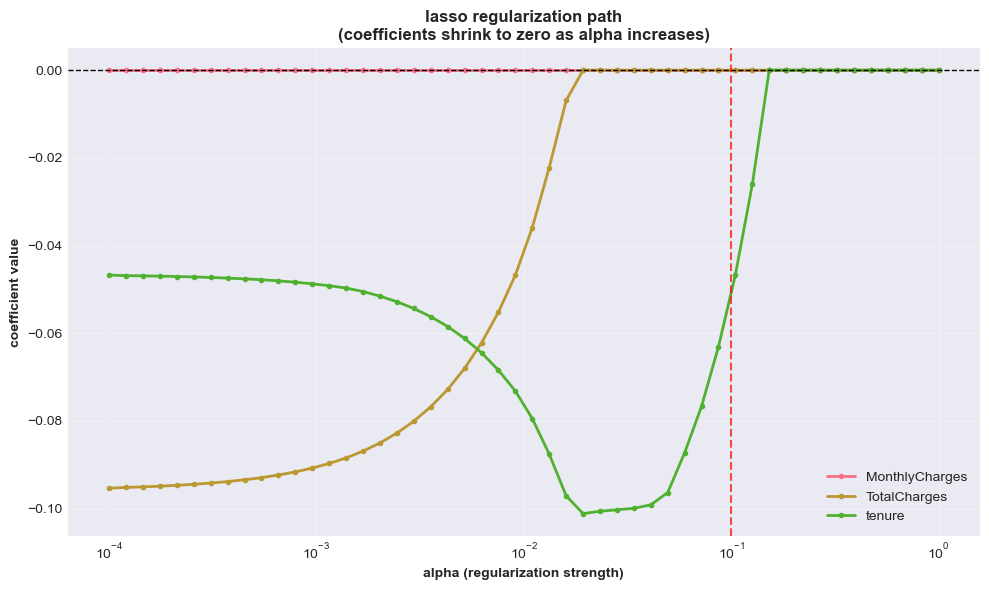

In [14]:
# lasso regularization path: shows how coefficients shrink to zero as alpha increases.
# this demonstrates the l1 penalty's ability to produce exact zeros in the solution,
# which is a consequence of the non-differentiability of the l1 norm at zero.
# reference: tibshirani, r. (1996). regression shrinkage and selection via the lasso.
#   journal of the royal statistical society: series b, 58(1), 267-288.
# reference: scikit-learn documentation on lasso:
#   https://scikit-learn.org/stable/modules/linear_model.html#lasso

fig, ax = plt.subplots(figsize=(10, 6))

alphas = np.logspace(-4, 0, 50)
lasso_coefs = []

track_features = ['MonthlyCharges', 'TotalCharges', 'tenure']
feature_indices = [list(X.columns).index(f) for f in track_features]

for alpha in alphas:
    lasso_temp = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso_temp.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso_temp.coef_)

for idx, feature in enumerate(track_features):
    coefs = [coef[feature_indices[idx]] for coef in lasso_coefs]
    ax.plot(alphas, coefs, marker='o', markersize=3, label=feature, linewidth=2)

ax.set_xscale('log')
ax.set_xlabel('alpha (regularization strength)', fontweight='bold')
ax.set_ylabel('coefficient value', fontweight='bold')
ax.set_title('lasso regularization path\n(coefficients shrink to zero as alpha increases)', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.axvline(x=alpha_lasso, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='selected alpha')

plt.tight_layout()
plt.show()

the lasso regularization path traces how individual feature coefficients change as the penalty strength (alpha) increases from left to right. at low alpha values (weak penalty), all three tracked features -- monthlycharges, totalcharges, and tenure -- have non-zero coefficients. as alpha increases, monthlycharges and totalcharges are the first to be driven to exactly zero, while tenure remains non-zero for longer, reflecting its stronger predictive importance. the red dashed vertical line marks the selected alpha (0.1), which sits well into the region where both charge features have already been eliminated and only the strongest predictors remain. this plot visually confirms that lasso performs variable selection: it does not just shrink coefficients, it removes features entirely once the penalty is strong enough.

### ridge regularization path

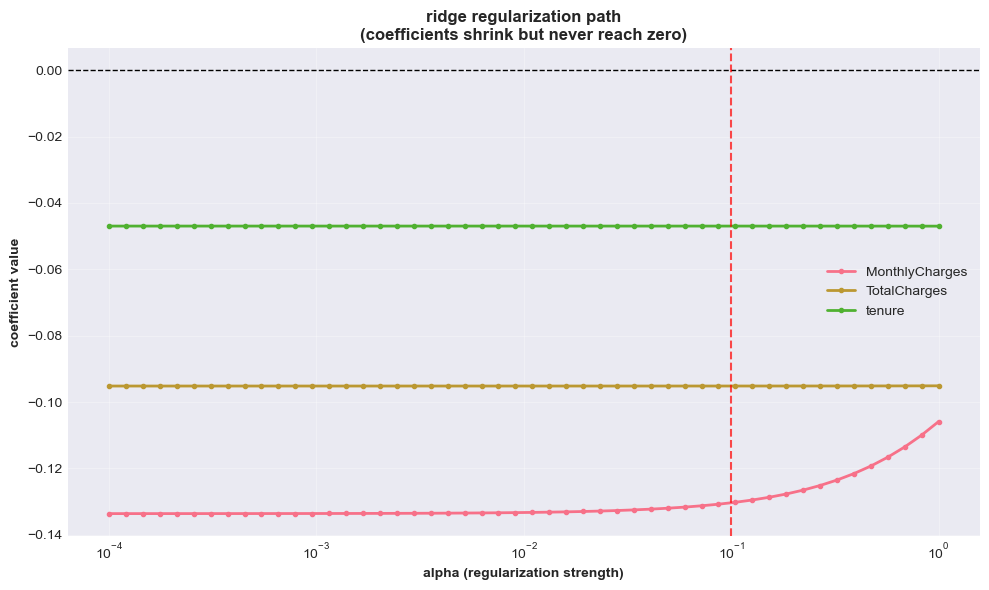

In [15]:
# ridge regularization path: shows how coefficients shrink toward zero but never
# reach it exactly. the l2 penalty distributes the penalty across all coefficients,
# keeping all features in the model with reduced magnitudes.
# reference: hoerl, a.e. & kennard, r.w. (1970). ridge regression: biased estimation
#   for nonorthogonal problems. technometrics, 12(1), 55-67.
# reference: scikit-learn documentation on ridge:
#   https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression

fig, ax = plt.subplots(figsize=(10, 6))

ridge_coefs = []
for alpha in alphas:
    ridge_temp = Ridge(alpha=alpha, random_state=42)
    ridge_temp.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge_temp.coef_)

for idx, feature in enumerate(track_features):
    coefs = [coef[feature_indices[idx]] for coef in ridge_coefs]
    ax.plot(alphas, coefs, marker='o', markersize=3, label=feature, linewidth=2)

ax.set_xscale('log')
ax.set_xlabel('alpha (regularization strength)', fontweight='bold')
ax.set_ylabel('coefficient value', fontweight='bold')
ax.set_title('ridge regularization path\n(coefficients shrink but never reach zero)', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.axvline(x=0.1, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='selected alpha')

plt.tight_layout()
plt.show()

the ridge regularization path shows the same three features across the same range of alpha values, but with a fundamentally different behavior. unlike lasso, none of the ridge coefficients ever reach zero. as alpha increases, all three coefficients shrink toward zero but remain non-zero at every point. monthlycharges and totalcharges maintain meaningful negative coefficients throughout, and tenure stays as the strongest predictor. this is the defining property of l2 (ridge) regularization: it penalizes the squared magnitude of coefficients, which shrinks them smoothly but never eliminates them. ridge is therefore better suited when all features are believed to carry some predictive value and none should be discarded entirely.

### feature count vs. alpha

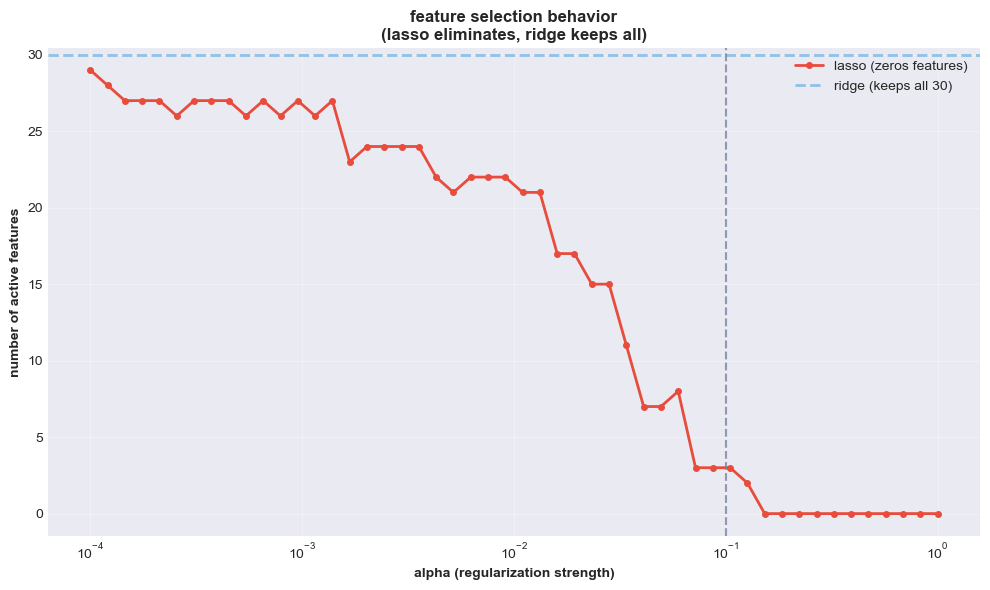

In [16]:
# feature count vs alpha: demonstrates the key behavioral difference between
# lasso and ridge. as alpha increases, lasso progressively eliminates features
# (setting coefficients to zero), while ridge retains all features regardless
# of the regularization strength.
# reference: james, g., witten, d., hastie, t., & tibshirani, r. (2013).
#   an introduction to statistical learning. springer. chapter 6.

fig, ax = plt.subplots(figsize=(10, 6))

non_zero_counts_lasso = []
non_zero_counts_ridge = []

for alpha in alphas:
    lasso_temp = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso_temp.fit(X_train_scaled, y_train)
    non_zero_counts_lasso.append(np.sum(lasso_temp.coef_ != 0))
    
    ridge_temp = Ridge(alpha=alpha, random_state=42)
    ridge_temp.fit(X_train_scaled, y_train)
    non_zero_counts_ridge.append(np.sum(np.abs(ridge_temp.coef_) > 0.001))

ax.plot(alphas, non_zero_counts_lasso, marker='o', markersize=4, 
        label='lasso (zeros features)', linewidth=2, color='#e74c3c')
ax.axhline(y=len(X.columns), linestyle='--', linewidth=2, alpha=0.5,
           label=f'ridge (keeps all {len(X.columns)})', color='#3498db')

ax.set_xscale('log')
ax.set_xlabel('alpha (regularization strength)', fontweight='bold')
ax.set_ylabel('number of active features', fontweight='bold')
ax.set_title('feature selection behavior\n(lasso eliminates, ridge keeps all)', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axvline(x=alpha_lasso, color='#e74c3c', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axvline(x=alpha_ridge, color='#3498db', linestyle='--', linewidth=1.5, alpha=0.5)

plt.tight_layout()
plt.show()

this plot summarizes the feature selection behavior of both models across the full range of alpha values. the red line shows that lasso's active feature count drops steadily as alpha increases -- from all 30 features at very low alpha down to just a handful at high alpha. the blue dashed line shows that ridge always retains all 30 features regardless of alpha. at lasso's selected alpha (0.1), the model uses only 3 features, while ridge at the same alpha still uses all 30. this plot makes it clear that lasso acts as a feature selector while ridge acts purely as a coefficient shrinker.

## model performance

In [17]:
# evaluate both models on the test set using a 0.5 threshold for binary classification.
# lasso uses fewer features (sparse model) while ridge uses all features.
# reference: james, g., witten, d., hastie, t., & tibshirani, r. (2013).
#   an introduction to statistical learning. springer. section 6.2.
lasso_pred = (lasso.predict(X_test_scaled) > 0.5).astype(int)
ridge_pred = (ridge.predict(X_test_scaled) > 0.5).astype(int)

print(f"\nlasso model (with {len(lasso_nonzeros)} features):")
print(f"  accuracy: {accuracy_score(y_test, lasso_pred):.4f}")

print(f"\nridge model (with all {len(X.columns)} features):")
print(f"  accuracy: {accuracy_score(y_test, ridge_pred):.4f}")


lasso model (with 3 features):
  accuracy: 0.7353

ridge model (with all 30 features):
  accuracy: 0.8226


## answering the assignment questions

### the "eliminator" (lasso): which features did lasso completely remove, and why is this helpful?

lasso (with alpha=0.1) eliminated 27 out of 30 features by setting their coefficients to exactly zero, keeping only 3:

**features kept (3):**
- **tenure** -- the strongest predictor; longer-tenured customers are less likely to churn.
- **internetservice_fiber optic** -- fiber optic customers churn at higher rates, possibly due to higher costs or service expectations.
- **paymentmethod_electronic check** -- customers paying by electronic check churn more, which may reflect less commitment compared to automatic payment methods.

**features eliminated (27):**
- **monthlycharges** and **totalcharges** -- both charge-related features were removed. they are correlated with each other (r=0.651) and with tenure, making them redundant when tenure is already in the model.
- **gender_male**, **partner_yes**, **dependents_yes**, **seniorcitizen** -- demographic features with weak relationships to churn.
- **phoneservice_yes**, **multiplelines_no phone service**, **multiplelines_yes** -- phone-related services that added little predictive value beyond the internet service features.
- **internetservice_no**, **onlinesecurity_yes**, **onlinesecurity_no internet service**, **onlinebackup_yes**, **onlinebackup_no internet service**, **deviceprotection_yes**, **deviceprotection_no internet service**, **techsupport_yes**, **techsupport_no internet service** -- internet-related add-on features whose information was already captured by the internetservice_fiber optic feature.
- **streamingtv_yes**, **streamingtv_no internet service**, **streamingmovies_yes**, **streamingmovies_no internet service** -- entertainment service features that were not strong churn indicators on their own.
- **contract_one year**, **contract_two year** -- contract type features, whose churn-reducing effect is largely captured by tenure.
- **paperlessbilling_yes** -- billing preference with a small effect that did not survive the penalty.
- **paymentmethod_credit card (automatic)**, **paymentmethod_mailed check** -- payment methods with negligible impact (lasso kept only electronic check, the strongest payment-related predictor).

**why this is helpful from a business perspective:** if you were the boss, a model that ignores certain pieces of data is valuable for several reasons. first, it tells you where to focus your attention -- instead of monitoring 30 variables, the team only needs to track 3. second, it reduces the cost and complexity of data collection; if gender, phone service, and streaming subscriptions do not predict churn, there is no need to invest in collecting or maintaining those data pipelines for this purpose. third, a simpler model is easier to explain to stakeholders and to act on -- it is much clearer to say "customers churn because of short tenure, fiber optic internet, and electronic check payments" than to present 30 weighted factors. finally, removing irrelevant features helps the model generalize better to new data by reducing the risk of overfitting to noise.

### the "balancer" (ridge): how did ridge treat monthlycharges and totalcharges differently than lasso?

ridge kept both monthlycharges (coefficient = -0.1304) and totalcharges (coefficient = -0.0952), while lasso eliminated both entirely (coefficients = 0.0000).

this difference comes down to how the two penalties work mathematically. lasso uses the l1 penalty (sum of absolute values), which has a sharp corner at zero that naturally pushes coefficients to become exactly zero. when two features are correlated, lasso tends to pick one or drop both rather than keep redundant information. ridge uses the l2 penalty (sum of squared values), which is smooth everywhere and never produces exact zeros. instead, ridge distributes the penalty across correlated features, shrinking both coefficients but keeping them non-zero.

in this case, monthlycharges and totalcharges have a pearson correlation of 0.651. ridge recognized that both features carry useful (albeit overlapping) information about churn and assigned them the two largest negative coefficients in the entire model. lasso, by contrast, decided that the predictive information in these charge features could be captured by the 3 features it kept (especially tenure, which strongly correlates with totalcharges), and removed both entirely.

the practical implication is that ridge preserves the full picture at the cost of a more complex model (all 30 features), while lasso trades some accuracy for a much simpler and more interpretable model with only 3 features.